#Toxic Comment Classification 
##Identify and classify toxic online comments

Giulia Cataldo, Bianca Cattaneo, Jacopo Signò

Dataset : https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data


## 2. BLSTM implementation


## Importing the libraries

In [41]:
import pandas as pd
import numpy as np
import spacy
import re as re
import urllib
import os
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sn
import pickle
import keras
import tensorflow
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers import Embedding, LSTM, SpatialDropout1D, Bidirectional, GlobalMaxPooling1D, Concatenate,LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
import os
import random

from IPython.core.pylabtools import figsize
mpl.style.use('ggplot') 

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading the Cleaned Dataset

In [43]:
with open('/content/drive/MyDrive/text_mex_project/data/new_dataset', 'rb') as f:
    df = pickle.load(f)

Removing **Stopwords**.

In [44]:
# We load the small spacy language library and we create a varible containg all the stopwords from this library 
en = spacy.load('en_core_web_sm')
stopwords = en.Defaults.stop_words

#removing stopwords
df['comment_text'] = df['comment_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

df.loc[:5,:]

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic,total_classes,y
0,sir hero chance remember page s,0,0,0,0,0,0,1,0,"0,0,0,0,0,0"
1,cocksucker piss work,1,1,1,0,1,0,0,4,"1,1,1,0,1,0"
2,hey talk exclusive group wp talibans good dest...,1,0,0,0,0,0,0,1,"1,0,0,0,0,0"
3,oh girl started arguments stuck nose doesn t b...,0,0,0,0,0,0,1,0,"0,0,0,0,0,0"
4,bye don t look come think comming tosser,1,0,0,0,0,0,0,1,"1,0,0,0,0,0"
5,barnstar real life barnstar lets stars,0,0,0,0,0,0,1,0,"0,0,0,0,0,0"


In [45]:
Class_count = {}                   
for col in df.iloc[:,1:7].columns:
    Class_count[col] = df[col].value_counts()[1] #.value_count return the number of 0 and 1 for each column, we are only interested in the 1

In [46]:
df1 = pd.DataFrame.from_dict(Class_count, orient ='index')
df1.rename(columns = {0:'Class Counts'}, inplace = True)
df1

,Class Counts
toxic,21384
severe_toxic,1962
obscene,12140
threat,689
insult,11304
identity_hate,2052


As stated before, the classes are clearly **unbalanced**. In particular, the class ***threat*** is the least represented.



##Data augmentation

Since we have really just a few sentences belongins to the *threat* category, the model will have a hard time learning when a sentence belongs to that category. We try to mitigate this behavior with some **data augmentation**.


Data augmentations are a set of methods used to generate synthetic data from the existing data. 

This process creates many variations of natural data, that can help us to:
- Address data scarcity
- Increase model's robustness
- Improve model's accuracy
- Reduce overfitting 
- Save resources to collect data and label 

In our case we use it primarily to address data scarcity, but also to increase the model's robustness.

For augmenting text data different techniques are available. 
We use the *synonym replacement*.

In this way we doubled the senteces labeled as *threat*


This first function identifies the synonyms of a given word and pre-processes them. 

In [47]:
import nltk
from nltk.corpus import wordnet 
nltk.download('wordnet')
nltk.download('omw-1.4')

def get_synonyms(word):
    """
    Get synonyms of a word
    """
    synonyms = set()
    
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


With the below function the synonyms are then randomly replaced in the original sentence.

In [48]:
def synonym_replacement(words, n):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stopwords]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence

In [49]:
data_to_augment = df.loc[df['threat'] == 1]
data_to_augment['comment_text'] = data_to_augment.iloc[:,0].apply(lambda x: synonym_replacement(x, 1) )

data_to_augment.shape

df = pd.concat([df, data_to_augment], axis = 0)
df = df.reset_index(drop=True)

<ipython-input-49-257cd39be8b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_augment['comment_text'] = data_to_augment.iloc[:,0].apply(lambda x: synonym_replacement(x, 1) )


In [50]:
Class_count = {}                   
for col in df.iloc[:,1:7].columns:
    Class_count[col] = df[col].value_counts()[1] #.value_count return the number of 0 and 1 for each column, we are only interested in the 1

df1 = pd.DataFrame.from_dict(Class_count, orient ='index')
df1.rename(columns = {0:'Class Counts'}, inplace = True)
df1

,Class Counts
toxic,22038
severe_toxic,2120
obscene,12579
threat,1378
insult,11749
identity_hate,2197


In [51]:
df.shape

(31089, 10)

Since classes are still unbalanced, we  ***sample data with stratification***.



In [52]:
# combnations of classes with the lowest occurrence
print(sum(df["y"].value_counts() == 1))

# number of unique combination of classes
print(df["y"].nunique())

# Filtering the rare combinations
df_filtered = df.groupby("y").filter(lambda x: len(x) > 1)
df_filtered.shape

df_filtered = df_filtered.reset_index(drop=True)


0
41


In [53]:
test_split = 0.35

# Initial train and test split.
train_df, test_df = train_test_split(
    df_filtered,
    test_size=test_split,
    stratify=df_filtered["y"],
)


# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)


Number of rows in training set: 20207
Number of rows in validation set: 5441
Number of rows in test set: 5441


We now check if the classes are ***represented in a similar way*** in all datasets.

In [54]:
col_labels = df.columns.tolist()[1:8]
train_df[col_labels] = np.array(train_df[col_labels], dtype=float)

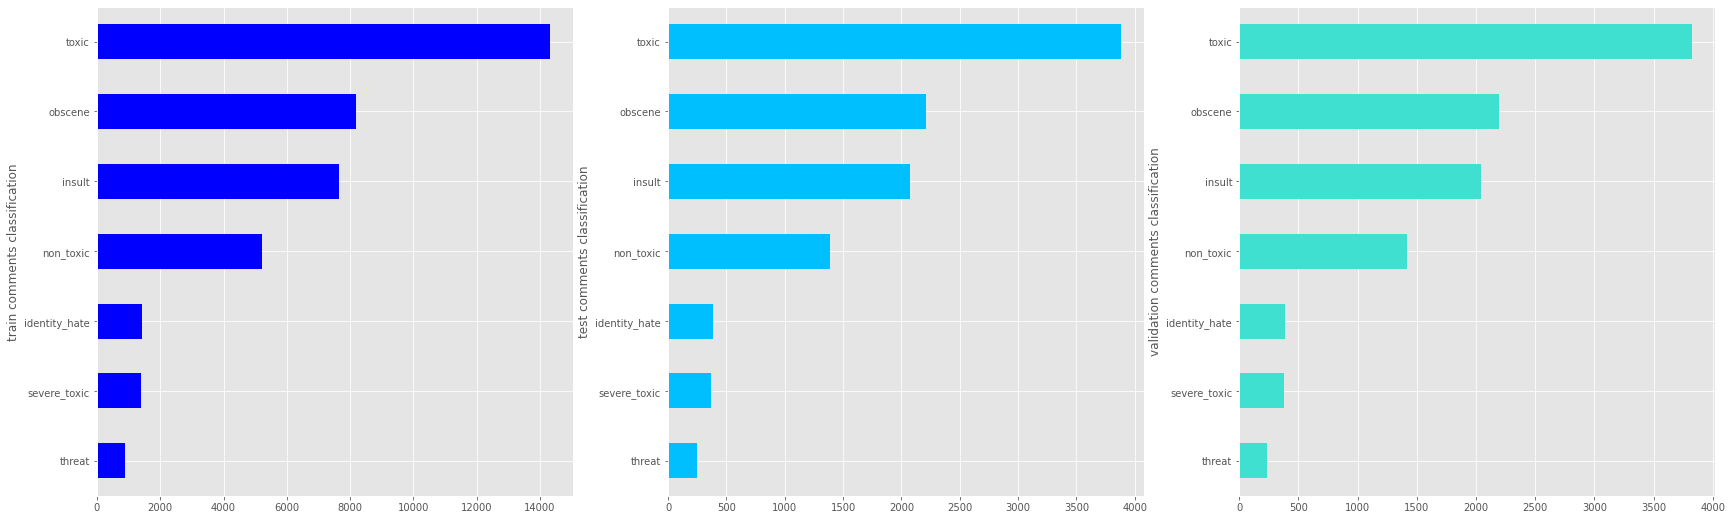

In [55]:
fig, axes = plt.subplots(nrows=1, ncols=3)

col_labels = train_df.columns.tolist()[1:8]
train_df[col_labels] = np.array(train_df[col_labels], dtype=float)
train_df[col_labels].sum().sort_values().plot(kind="barh", ax=axes[0], figsize=(20, 10), ylabel="train comments classification", color='blue')

col_labels = test_df.columns.tolist()[1:8]
test_df[col_labels] = np.array(test_df[col_labels], dtype=float)
test_df[col_labels].sum().sort_values().plot(kind="barh", ax=axes[1], figsize=(20, 10), ylabel= "test comments classification", color='deepskyblue')

col_labels = val_df.columns.tolist()[1:8]
val_df[col_labels] = np.array(val_df[col_labels], dtype=float)
val_df[col_labels].sum().sort_values().plot(kind="barh", ax=axes[2], figsize=(29, 9), ylabel= "validation comments classification", color='turquoise')

plt.show()

In order to decide the maximum length for padding, let us look at the **length of the comments**: 

In [56]:
# Max length of Input Sequence
def len_(x):
  a = x.split()
  return len(a)

print(max(df['comment_text'].apply(len_)))

# Percentile length 
df['comment_len'] = (df['comment_text'].apply(len_))
print(np.percentile(df.comment_len, [25, 50, 90, 96]))

1963
[  6.  12.  53. 104.]


We can notice from the percentiles that 96% of the sentences have less than 105 token  

In [57]:
df['comment_len'] = np.array(df['comment_len'], dtype=float)
df.head(3)

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic,total_classes,y,comment_len
0,sir hero chance remember page s,0,0,0,0,0,0,1,0,"0,0,0,0,0,0",6.0
1,cocksucker piss work,1,1,1,0,1,0,0,4,"1,1,1,0,1,0",3.0
2,hey talk exclusive group wp talibans good dest...,1,0,0,0,0,0,0,1,"1,0,0,0,0,0",28.0


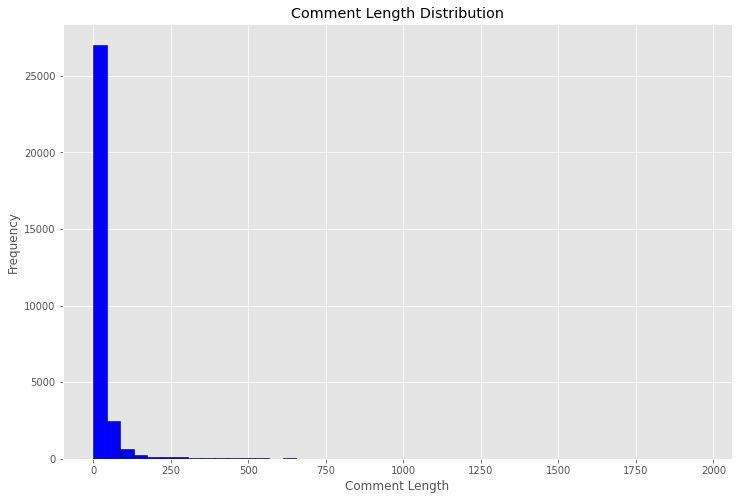

In [58]:
figsize(12,8)

# add a title to the histogram
plt.title('Comment Length Distribution')
# add y-label
plt.ylabel('Frequency')
# add x-label
plt.xlabel('Comment Length')

plt.hist(df['comment_len'], color='blue', edgecolor='black', bins=int(45/1))
plt.show()



Since the majority of the comments has length between 1 and 105, let us choose  a maximum length equal to **100**.

## Tokenization of the datasets

A `Tokenizer` object allows us to associate to each word a relative id

In [59]:
# Creating X_train_strat, X_val_strat, X_test_strat (assigning integers to words).

# Size of Vocabulary
vect = Tokenizer(num_words = 55485, split = ' ') # num_words = the maximum number of words to keep, based on word frequency. 
                                                 # Only the most common words will be kept.
vect.fit_on_texts(df['comment_text'].values)     # .values Return a Numpy representation of the DataFrame
vocab_size = len(vect.word_index)
print(f' the size of the vocabulary is {vocab_size}')

# We tokenize each senteces, and then we pad all sentences to a len of 100
X_train_strat = vect.texts_to_sequences(train_df['comment_text'].values)
X_train_strat = pad_sequences(X_train_strat, maxlen=100, padding='post')

X_val_strat = vect.texts_to_sequences(val_df['comment_text'].values)
X_val_strat = pad_sequences(X_val_strat, maxlen=100, padding='post')

X_test_strat = vect.texts_to_sequences(test_df['comment_text'].values)
X_test_strat = pad_sequences(X_test_strat, maxlen=100, padding='post')

 the size of the vocabulary is 55488


In [60]:
# Creating Y_train_strat, Y_val_strat, Y_test_strat, trasforming the y from string to np.array 
# Creating Y_train_strat, Y_val_strat, Y_test_strat, trasforming the y from string to np.array 

def creating_y(A):
  s_array = A.to_numpy()
  s_array = [list(x[0].split(',')) for x in s_array]
  s_array[:] = [list(map(int, x)) for x in s_array[:]]
  s_array = np.array([np.array(x) for x in s_array])

  return s_array 
  
Y_train_strat = creating_y(train_df[['y']])
Y_val_strat = creating_y(val_df[['y']]) 
Y_test_strat = creating_y(test_df[['y']])


## Useful Parameters



In [61]:
MAX_VOCAB_SIZE = 55485

EMBEDDING_DIM = 100 # pre-trained embeddings only come in specific sizes, so we can only use 50,100,200 or 300

BATCH_SIZE = 64

EPOCHS = 10

## Word embeddings

Almost all Deep Learning Architectures are incapable of processing text, so we need to pass them a sequence of numbers. There are different techniques that allow to trasform words into vector of numbers.

**Word embeddings** are a class of techniques where individual words are represented as real-valued vectors in a predefinited vector space, in particular word embeddings allows words with similar meaning to have a similar representation.

Between different embedding techniques we decide to use **GloVe**(Global Vectors for Word Representation). GloVe allowes to looks at how often a word *j* appears in the context of a word *i* within all our corpus of text.

In [62]:
embeddings_index = {}
with open(os.path.join('/content/drive/MyDrive/text_mex_project/data/glove.6B.100d.txt'),encoding='utf8') as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [63]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

In [64]:
targets = train_df[labels].values 

# targets shape : (Num of Samples,Num of target labels)
targets.shape

(20207, 6)

## Prepare embedding matrix

In [65]:
word2idx = vect.word_index #it's a dictionary containing for each token a relative indx 
print('Number of Unique tokens are : {}'.format(len(word2idx)) ) 

Number of Unique tokens are : 55488


In [66]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1) 
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

In [67]:
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM)) 

In [68]:
embedding_matrix.shape

# We have successfully trucnated and created an embedding matrix of dimension (MAX_VOCAB_SIZE,EMBEDDING_DIM )
# Now we have to index it using the words from the pre-trained word2vec to create pre-trained embedding matrix 

(55485, 100)

In [69]:
num_tokens = len(word2idx)+2
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, EMBEDDING_DIM)) 

for word, i in word2idx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 37946 words (17542 misses)


At this point we have a matrix that contain for each word (or at least for each word found in the Glove vocabolary) the corresponding vector rappresentation according to the GloVe technique

## Loading pre-trained word embeddings into an Embedding layer

In [70]:
embedding_layer = Embedding(
    num_tokens,
    EMBEDDING_DIM, #100
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

## Building the Model

To achive our goal we decide to implement a Bidirectional Long Short-Term Memory(BLSTM)

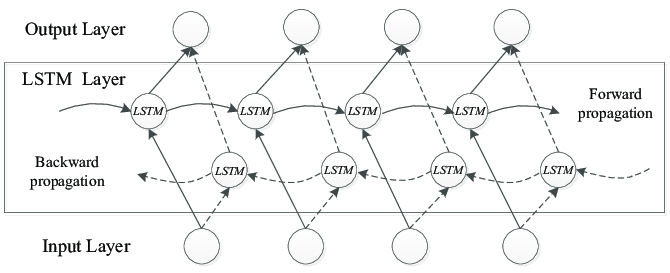

The BLSTM architecure is based on the simplier LSTM.

LSTM in its core, preserves information from inputs that has already passed through it using the hidden state.

The main limitaiton of unidirectional LSTM is that it only preserves information from the past because the only inputs it has seen are from the past.

BLSTM receives the input in two ways, one from past to future and one from future to past. The differenc between this approach ad the  unidirectional approach is that in the BLSTM we can preserve information from the future and using the two hidden states combined it is able in any point in time to preserve information from both past and future.

In [71]:
from keras.layers import ELU, PReLU, LeakyReLU

In [72]:
act = keras.layers.PReLU()

model = Sequential()
# Configuring the parameters
model.add(embedding_layer) 
model.add(Bidirectional(LSTM(128, return_sequences=True)))
# Adding a dropout layer
model.add(SpatialDropout1D(0.3))
model.add(LSTM(128))
model.add(Dropout(0.2))
# Adding a dense output layer with sigmoid activation
model.add(Dense(64))
model.add(LeakyReLU())
model.add(Dense(64))
model.add(LeakyReLU())
model.add(Dense(len(labels), activation='sigmoid'))
model.compile(optimizer = Adam(lr=0.0007), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         5549000   
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 256)        234496    
 nal)                                                            
                                                                 
 spatial_dropout1d_1 (Spatia  (None, None, 256)        0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 128)               197120    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)               

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**final layer**: 

*Why Sigmoid and not Softmax in the final dense layer?*

In the final layer of the above architecture, sigmoid function has been used instead of softmax. The advantage of using sigmoid over Softmax lies in the fact that **one comment may have many possible classifications**. 
Using the Softmax function would imply that the probability of occurrence of one tag depends on the occurrence of other tags. But for this application, we need a function that would give scores for the occurrence of tags, which would be independent of occurrences of any other comment tag (probabilities are not constrained to sum to one).

In [73]:
#early_stopping_callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=3, verbose=1, mode="auto", restore_best_weights=True)

%timeit
history = model.fit(X_train_strat, 
                    Y_train_strat, 
                    epochs = EPOCHS, 
                    batch_size = BATCH_SIZE, 
                    verbose = 2,
                    #callbacks=[early_stopping_callback],
                    validation_data=(X_val_strat, Y_val_strat))

Epoch 1/10
316/316 - 11s - loss: 0.4156 - accuracy: 0.9476 - val_loss: 0.3871 - val_accuracy: 0.9638 - 11s/epoch - 35ms/step
Epoch 2/10
316/316 - 6s - loss: 0.4134 - accuracy: 0.9660 - val_loss: 0.4055 - val_accuracy: 0.9638 - 6s/epoch - 17ms/step
Epoch 3/10
316/316 - 6s - loss: 0.4033 - accuracy: 0.9660 - val_loss: 0.3765 - val_accuracy: 0.9638 - 6s/epoch - 18ms/step
Epoch 4/10
316/316 - 6s - loss: 0.3125 - accuracy: 0.9661 - val_loss: 0.2873 - val_accuracy: 0.9638 - 6s/epoch - 18ms/step
Epoch 5/10
316/316 - 6s - loss: 0.2893 - accuracy: 0.9652 - val_loss: 0.2817 - val_accuracy: 0.9638 - 6s/epoch - 18ms/step
Epoch 6/10
316/316 - 6s - loss: 0.2809 - accuracy: 0.9649 - val_loss: 0.2782 - val_accuracy: 0.9638 - 6s/epoch - 18ms/step
Epoch 7/10
316/316 - 6s - loss: 0.2747 - accuracy: 0.9651 - val_loss: 0.2767 - val_accuracy: 0.9638 - 6s/epoch - 18ms/step
Epoch 8/10
316/316 - 6s - loss: 0.2666 - accuracy: 0.9641 - val_loss: 0.2673 - val_accuracy: 0.9638 - 6s/epoch - 18ms/step
Epoch 9/10
316

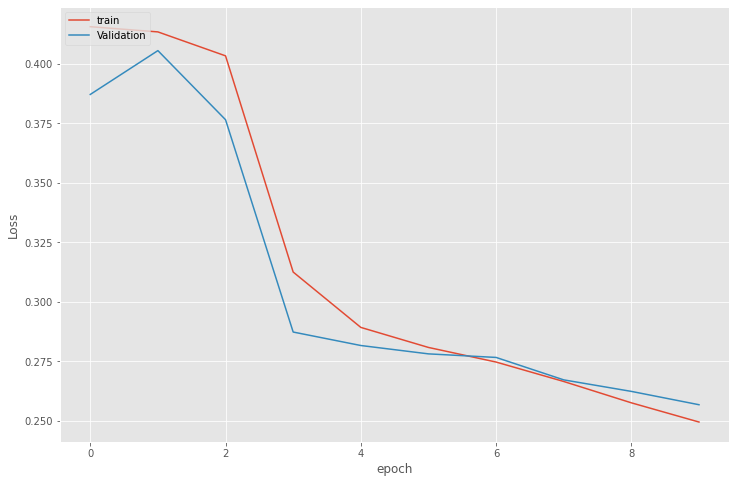

In [74]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

## Predictions

In [75]:
predictions = model.predict(X_test_strat)
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(Y_test_strat, pred, average='micro',)
    recall = recall_score(Y_test_strat, pred, average='micro')
    f1 = f1_score(Y_test_strat, pred, average='micro')
   
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}, Treshold: {:.4f}".format(precision, recall, f1, val))

171/171 [==============================] - 2s 7ms/step
Micro-average quality numbers
Precision: 0.5738, Recall: 0.9541, F1-measure: 0.7166, Treshold: 0.1000
Micro-average quality numbers
Precision: 0.6641, Recall: 0.9104, F1-measure: 0.7680, Treshold: 0.2000
Micro-average quality numbers
Precision: 0.7352, Recall: 0.8608, F1-measure: 0.7931, Treshold: 0.3000
Micro-average quality numbers
Precision: 0.7880, Recall: 0.8051, F1-measure: 0.7965, Treshold: 0.4000
Micro-average quality numbers
Precision: 0.8350, Recall: 0.7445, F1-measure: 0.7871, Treshold: 0.5000
Micro-average quality numbers
Precision: 0.8701, Recall: 0.6937, F1-measure: 0.7720, Treshold: 0.6000
Micro-average quality numbers
Precision: 0.9011, Recall: 0.6431, F1-measure: 0.7505, Treshold: 0.7000
Micro-average quality numbers
Precision: 0.9286, Recall: 0.5576, F1-measure: 0.6968, Treshold: 0.8000
Micro-average quality numbers
Precision: 0.9619, Recall: 0.3803, F1-measure: 0.5450, Treshold: 0.9000


In [76]:
score,acc = model.evaluate(X_test_strat, Y_test_strat, verbose = 2, batch_size = BATCH_SIZE)
print("acc: %.2f" % (acc))

86/86 - 1s - loss: 0.2620 - accuracy: 0.9680 - 591ms/epoch - 7ms/step
acc: 0.97


In [77]:
THRESHOLD = 0.5

y_pred = predictions
y_true = Y_test_strat
y_pred = np.where(y_pred > THRESHOLD, 1, 0)
print(classification_report(
  y_true,
  y_pred,
  target_names=labels,
  zero_division=0
))

               precision    recall  f1-score   support

        toxic       0.89      0.96      0.92      3885
 severe_toxic       0.45      0.23      0.30       367
      obscene       0.84      0.79      0.81      2211
       threat       0.60      0.04      0.07       246
       insult       0.75      0.59      0.67      2075
identity_hate       0.43      0.10      0.17       381

    micro avg       0.84      0.74      0.79      9165
    macro avg       0.66      0.45      0.49      9165
 weighted avg       0.80      0.74      0.76      9165
  samples avg       0.63      0.57      0.57      9165



In [78]:
type(Y_test_strat[1])


numpy.ndarray

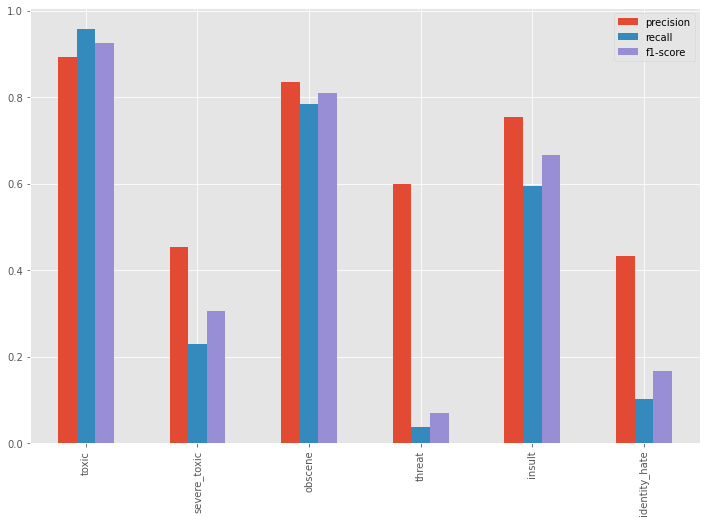

In [79]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

report1 = classification_report(y_true, 
                                y_pred, digits=2,
                                zero_division = 0,
                                output_dict=True)
  
df_ = pd.DataFrame(report1)
df_.rename(columns={'0': 'toxic', '1': 'severe_toxic', '2': 'obscene', '3': 'threat', '4': 'insult', '5': 'identity_hate'}, inplace=True)
df_.iloc[:3, :6].T.plot(kind='bar', figsize=(12, 8))
plt.show()

## Testing our model on a made up comment

In [80]:
test_comment = ["I will kill you"]
test_comment = vect.texts_to_sequences(np.array(test_comment))
test_comment = pad_sequences(test_comment, maxlen=100, padding='post')
test_prediction = model.predict(test_comment)

for label, prediction in zip(labels, test_prediction.flatten()):
  if prediction < THRESHOLD:
    continue
  print(f"{label}: {prediction}")



1/1 [==============================] - 0s 20ms/step
toxic: 0.8846198916435242
